In [7]:
import numpy as np
import csv
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import multiprocessing as mp
from scipy.integrate import odeint

In [8]:
# generate a network structure
def network(param_nx, structure = 'complete'):
    '''
    param_nx: dictionary of parameters
    structure: type of network
    '''
    if structure == 'complete': # complete graph
        G = nx.complete_graph(param_nx['N'])
    elif structure == 'lattice': # two-dimensional grid graph (square or rectangle)
        G = nx.grid_2d_graph(param_nx['L'], param_nx['H'], periodic = True) 
    elif structure == 'ER': # Erdős-Rényi graph
        G = nx.erdos_renyi_graph(param_nx['N'], param_nx['p'])
    elif structure == 'WS': # Watts–Strogatz small-world graph
        G = nx.watts_strogatz_graph(param_nx['N'], param_nx['k'], param_nx['b'])
    elif structure == 'BA': # Barabási–Albert preferential attachment
        G = nx.barabasi_albert_graph(param_nx['N'], param_nx['m'])

    print(nx.info(G)) # basic information
    return nx.to_numpy_array(G) # adjacency matrix

In [12]:
def SIR_Gillespie(N, y_0, param,tag = 'SIR'):
    '''
    N: population size
    y_0: initial condition of the population
    param: dictionary of the parameters
    tag: output object
    '''
    # initialization
    beta, gamma = param['beta']/N, param['gamma']
    I_0 = int(N*y_0[1])
    t = [0]; S = [N - I_0]; I = [I_0]; R = [0]
    state = np.array([0]*S[0] + [1]*I[0]).reshape((N, )) # S: 0, I: 1, R: 2
    np.random.shuffle(state)
    prop = beta*I[0]*(state == 0) + gamma*(state == 1)
    
    # update
    while I[-1] > 0:
        r_1 = np.random.rand()
        r_2 = np.random.rand()
        cumsum = prop.cumsum()
        scale = cumsum[-1] # total rate, or beta*S[-1]*I[-1] + gamma*I[-1]
        tau = -np.log(1 - r_1)/scale # exponential distribution: inverse function
        t.append(t[-1] + tau)

        i = np.searchsorted(cumsum, r_2*scale)
        if state[i] == 0: 
            S.append(S[-1] - 1); I.append(I[-1] + 1); R.append(R[-1])
            state[i] = 1 # S to I
            prop[i] = gamma
        else:
            S.append(S[-1]); I.append(I[-1] - 1); R.append(R[-1] + 1)
            state[i] = 2 # I to R
            prop[i] = 0
        prop[state == 0] = beta*I[-1]

    if tag == 'SIR':
        S = np.array(S); I = np.array(I); R = np.array(R)
        solution = np.column_stack((S, I, R))
        return t, solution 
    else:
        return state


In [13]:
# structured population
## SIR model: agent-based simulation
def SIR_network_Gillespie(A, y_0, param, output = 'solution'):
    '''
    A: adjacency matrix
    y_0: initial condition of the population
    param: dictionary of the parameters
    output: output object
    '''
    # initialization
    N = A.shape[0]; degree = np.sum(A)/A.shape[0]
    beta, gamma = param['beta']/degree, param['gamma']
    I_0 = int(N*y_0[1])
    t = [0]; S = [N - I_0]; I = [I_0]; R = [0]
    state = np.array([0]*S[0] + [1]*I[0]).reshape((N, ))
    np.random.shuffle(state)
    # compared with well-mixed population: beta*I[0]*(state == 0) + gamma*(state == 1)
    prop = beta*A.dot(state == 1)*(state == 0) + gamma*(state == 1) 
    # update
    while I[-1] > 0:
        r_1 = np.random.rand()
        r_2 = np.random.rand()
        cumsum = prop.cumsum()
        scale = cumsum[-1]
        tau = -np.log(1 - r_1)/scale 
        t.append(t[-1] + tau)
        i = np.searchsorted(cumsum, r_2*scale)
        if state[i] == 0: 
            S.append(S[-1] - 1); I.append(I[-1] + 1); R.append(R[-1])
            state[i] = 1
        else:
            S.append(S[-1]); I.append(I[-1] - 1); R.append(R[-1] + 1)
            state[i] = 2 
        # update propensities (neighborhood affected)  
        prop = beta*A.dot(state == 1)*(state == 0) + gamma*(state == 1) 
        
    if output == 'solution':
        S = np.array(S); I = np.array(I); R = np.array(R)
        solution = np.column_stack((S, I, R))
        return t, solution
    else:
        return state

In [14]:
# well-mixed population
## ODE equation
### SIR model: numerical solution
def SIR_equation(y, t, param):
    beta, gamma = param['beta'], param['gamma']
    S, I, R = y
    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]
def SIR(y_0, t, param):
    solution = odeint(SIR_equation, y_0, t, args = (param, ))
    return solution


C:\Users\Yuan\AppData\Local\Temp\ipykernel_12672\4094712956.py:18: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G)) # basic information


Graph with 1000 nodes and 499500 edges
ODE: 0.033729, 0.000745, 0.965526
gillespie: 0.03344, 0.0, 0.96656
time: 4.598289
network_Gillespie: 0.03289, 0.0, 0.96711
time: 86.143329


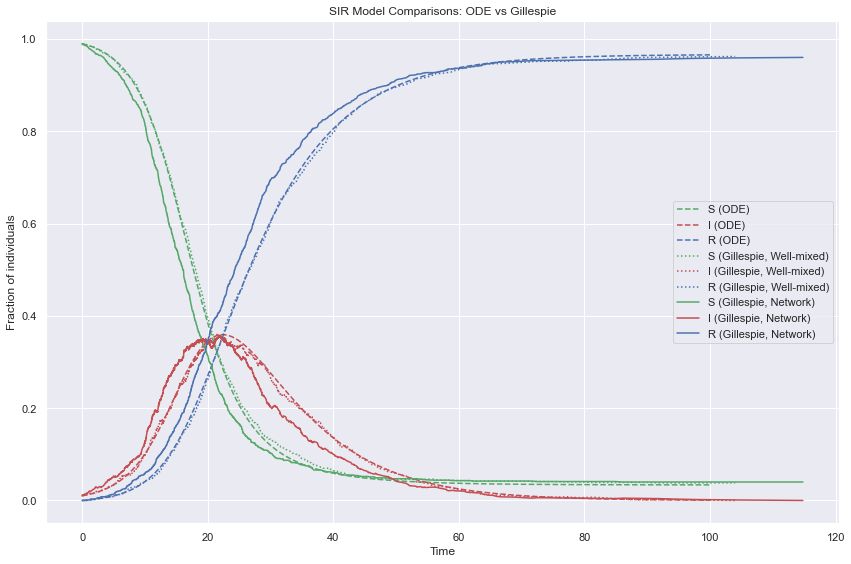

In [18]:
# Generate a network complete graph for network-based simulation
# SIR
N = 1000; A = network({'N': N}, structure = 'complete')
y_0 = [1 - 1e-2, 1e-2, 0]; param = {'beta': 0.35, 'gamma': 0.1}


# ODE simulation
t_ode = np.linspace(0, 100, 1001)
solution_ode = SIR(y_0, t_ode, param)
solution_ode = np.around(solution_ode, decimals=6)
print('ODE: ' + ", ".join([str(v) for v in solution_ode[-1]]))


# Gillespie simulation for well-mixed population
t_gillespie, solution_gillespie = SIR_Gillespie(N, y_0, param)
repetition = 100
start = time.time()
mean_SIR = np.zeros(3)
for i in range(repetition):
     t_1, solution_1 = SIR_Gillespie(N, y_0, param); mean_SIR += solution_1[-1]
mean_SIR = mean_SIR/repetition/N; mean_SIR = np.around(mean_SIR, decimals = 6)
end = time.time()
print('gillespie' + ': ' + ", ".join([str(v) for v in mean_SIR]))
print('time: ' + str(np.around(end - start, decimals = 6)))


# Gillespie simulation for structured population (network-based)
t_network, solution_network = SIR_network_Gillespie(A, y_0, param)
repetition = 100
start = time.time()
mean_SIR = np.zeros(3)
for i in range(repetition):
    t, solution = SIR_network_Gillespie(A, y_0, param, output = 'solution'); mean_SIR += solution[-1]
mean_SIR = mean_SIR/repetition/N; mean_SIR = np.around(mean_SIR, decimals = 6)
end = time.time()
print('network_Gillespie' + ': ' + ", ".join([str(v) for v in mean_SIR]))
print('time: ' + str(np.around(end - start, decimals = 6)))


# Plotting
plt.figure(figsize=(12, 8))

# ODE results
plt.plot(t_ode, solution_ode[:, 0], 'g--', label='S (ODE)')
plt.plot(t_ode, solution_ode[:, 1], 'r--', label='I (ODE)')
plt.plot(t_ode, solution_ode[:, 2], 'b--', label='R (ODE)')

# Gillespie results for well-mixed
plt.plot(t_gillespie, solution_gillespie[:, 0]/N, 'g:', label='S (Gillespie, Well-mixed)')
plt.plot(t_gillespie, solution_gillespie[:, 1]/N, 'r:', label='I (Gillespie, Well-mixed)')
plt.plot(t_gillespie, solution_gillespie[:, 2]/N, 'b:', label='R (Gillespie, Well-mixed)')

# Gillespie results for network
plt.plot(t_network, solution_network[:, 0]/N, 'g', label='S (Gillespie, Network)')
plt.plot(t_network, solution_network[:, 1]/N, 'r', label='I (Gillespie, Network)')
plt.plot(t_network, solution_network[:, 2]/N, 'b', label='R (Gillespie, Network)')

plt.xlabel('Time')
plt.ylabel('Fraction of individuals')
plt.title('SIR Model Comparisons: ODE vs Gillespie')
plt.legend()
plt.tight_layout()
plt.show()
